# Hopfield Net

In [24]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [25]:
# Implementation for asynchronous Hopfield neural network
# Note: memory capacity ≃ 0.14*nodes
class Hopfield_Neural_Network:
    def __init__(self,nodes,iterations=100,weights=None):
        self.nodes = nodes
        self.iterations = iterations
        try:
            if weights == None:
                self.weights = np.zeros((nodes,nodes))
        except ValueError:
            self.weights = weights
    
    def store(self,input):
        dW = np.outer(input,input)
        np.fill_diagonal(dW,0)
        self.weights += dW
        
    def recall(self,input,range_=None):
        # Can specify range of nodes to iterate over (i.e. nodes that are "input" may be known as correct)
        if type(range_) == tuple:
            a = range(range_[0],range_[1])
        else:
            a = self.nodes
        update_sequence = np.random.choice(a, self.iterations)
        for node in update_sequence:
            input[node] = np.sign(np.inner(input,self.weights[:,node]))
            if input[node] == 0: # this was missing
                input[node] = -1
        return input
    
    def setIter(self,iter_):
        self.iterations = iter_
    
    def save_weights(self,filename):
        np.save(filename, self.weights)
        
    def load_weights(self,filename):
        weights = np.load(filename)
        if weights.shape == (self.nodes, self.nodes):
            self.weights = weights
        else:
            raise ValueError("Dimensions of specified weight array does not match network weight dimensions!")

# Data

### Matrices

In [26]:
import re

In [27]:
class matrix_expansion:
    
    def __init__(self,active_motors):
        self.active_motors = active_motors
        active_sensors = np.array(active_motors*2)
        active_sensors[len(active_motors):] += 14
        self.active_sensors = active_sensors
        self.shape = ()
        
    def load_from_file(self,filename):
        f = open(filename,"r")
        matrix = f.read()
        f.close()
        matrix = re.split(",NEW_ROW,",matrix)
        matrix.pop()
        matrix = np.array([np.array(re.split(",", row)).astype(np.float) for row in matrix])
        self.shape = matrix.shape
        return matrix
        
    def reduced_matrix(self,matrix):
        matrix = matrix[:,self.active_sensors][self.active_motors]
        return matrix
    
    def expanded_matrix(self,reduced_matrix):
        matrix = np.zeros(self.shape)
        flat = reduced_matrix.flatten()
        matrix = np.zeros((14,28))
        k = 0
        for i in active_motors:
            for j in active_sensors:
                matrix[i,j] = flat[k]
                k += 1
        return matrix

In [28]:
active_motors = [1,3,4,5,10,12]
expander = matrix_expansion(active_motors)

In [29]:
# Front back
filename = "/home/markus/dep/dep_matrices/front_back.dep"
fb_matrix = expander.load_from_file(filename)
fb_reduced = expander.reduced_matrix(fb_matrix)
#fb_expanded = expander.expanded_matrix(fb_reduced)

In [30]:
# Front side
filename = "/home/markus/dep/dep_matrices/front_side.dep"
fs_matrix = expander.load_from_file(filename)
fs_reduced = expander.reduced_matrix(fs_matrix)
#fs_expanded = expander.expanded_matrix(fs_reduced)

In [31]:
# Side down
filename = "/home/markus/dep/dep_matrices/side_down.dep"
sd_matrix = expander.load_from_file(filename)
sd_reduced = expander.reduced_matrix(sd_matrix)
#sd_expanded = expander.expanded_matrix(sd_reduced)

In [32]:
# Zero
zero_reduced = np.zeros(fb_reduced.shape)

In [33]:
matrices = {"fb": fb_reduced, "fs": fs_reduced, "sd": sd_reduced, "zero": zero_reduced}

### Transition points

In [34]:
import pickle

In [35]:
behaviors = ["zero","fb","fs","sd"]
transitions = {("fb","fs"): [], ("fb","sd"): [], ("fs","fb"): [], ("fs","sd"): [], ("sd","fb"): [], ("sd","fs"): []}

# generate all transition combinations (including zero and "self-transitions")
#transitions = {}
#for behavior_1 in behaviors:
#    for behavior_2 in behaviors:
#        transitions[(behavior_1,behavior_2)] = []

In [36]:
fb = pickle.load(open("/home/markus/dep/dep_data/bases/fb.pickle","rb"))
fs = pickle.load(open("/home/markus/dep/dep_data/bases/fs.pickle","rb"))
sd = pickle.load(open("/home/markus/dep/dep_data/bases/sd.pickle", "rb"))
zero = []
for array in fb:
    zero.append(np.zeros(array.shape))

bases = {"fb": fb, "fs": fs, "sd": sd}#, "zero": zero}

In [37]:
# obtained from plot, time indices that meat transition_muscle_2 condition
fb_t = 124
fs_t = 126
sd_t = 117
zero_t = 0

In [38]:
# pos data
pos = {"fb": fb[0][fb_t][active_motors], "fs": fs[0][fs_t][active_motors], "sd": sd[0][sd_t][active_motors], "zero": zero[0][zero_t][active_motors]}
# vel data
vel = {"fb": fb[1][fb_t][active_motors], "fs": fs[1][fs_t][active_motors], "sd": sd[1][sd_t][active_motors], "zero": zero[1][zero_t][active_motors]}

### Brain ID

In [39]:
behaviors = ["zero","fb","fs","sd"]
n = len(behaviors)
start = 0.0
width = 1.0/float(n)
brain_ranges = {}
for i in range(1,n+1):
    brain_ranges[behaviors[i-1]] = ((i-1)*width-start, i*width-start)
brain_id = {}
for behavior in behaviors:
    brain_id[behavior] = (brain_ranges[behavior][0]+brain_ranges[behavior][1])/2
# "zero = [0.0,0.25], "fb" = [0.25,0.5], "fs" = [0.5, 0.75], "sd" = [0.75,1.00]
#brain_id = {"zero": 0.125, "fb": 0.375, "fs": 0.625, "sd": 0.875}

# Encoding

In [40]:
# HTM SDR Scalar Encoder
# Input: Scalar
# Parameters: n - number of units, w - bits used to represent signal (width), b - buckets (i.e. resolution), 
#             min - minimum value of input (inclusive), max - maximum input value (inclusive)
class scalar_sdr:
    
    def __init__(self, b, w, min_, max_, shape=(1,1), neg=True):
        if type(b) != int or type(w) != int or type(min_) != float or type(max_) != float:
            raise TypeError("b - buckets must be int, w - width must be int, min_ must be float and max_ must be float")
        self.b = b # must be int
        self.w = w # must be int
        self.min = min_ # must be float
        self.max = max_ # must be float
        self.n = b+w-1 # number of units for encoding
        self.ndarray_shape = shape
        self.nodes = self.n*reduce(lambda x, y: x*y, self.ndarray_shape)
        self.neg = neg
        
    def encode(self,input_):
        if input_ > self.max or input_ < self.min:
            raise ValueError("Input outside encoder range!")
        if type(input_) != float:
            raise TypeError("Input must be float!")
        if self.neg:
            output = np.zeros(self.n)-1
        else:
            output = np.zeros(self.n)
        index = int((input_-self.min)/(self.max-self.min)*self.b)
        output[index:index+self.w] = 1
        return output
    
    def encode_ndarray(self,input_):
        if input_.shape != self.ndarray_shape:
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        output = []
        for i in np.nditer(input_, order='K'):
            output.append(self.encode(float(i)))
        return np.array(output)
    '''
    def decode(self,input_):
        if len(input_) != self.n: # or len(np.nonzero(input_+1)[0]) != self.w: <-- Can't have since the network is not guaranteed to produce this by any means!!!
            raise TypeError("Input does not correspond to encoder encoded data!")
        # output = np.nonzero(input_+1)[0][0]/float(self.b)*(self.max-self.min)+self.min <-- This doesn't work really since bits can randomly fire, taking the average is a more reasonable decoding
        median = np.median(np.nonzero(input_+1)[0])            
        try:
            output = int(median-float(self.w)/2.0)/float(self.b)*(self.max-self.min)+self.min # i.e. figure out center (median more outlier resistant than mean) and subtract width/2
        except ValueError:
            output = None
        return output
    '''
    def decode(self,input_):
        if len(input_) != self.n: 
            raise TypeError("Input length does not match encoder length!")
        if len(np.nonzero(input_+1)[0]) == 0:
            return np.nan
        max_ = 0
        output = 0.0
        for i in range(self.b):
            x = np.zeros(self.n)-1
            x[i:i+self.w] = 1
            if x.shape != input_.shape:
                input_ = input_.reshape(x.shape)
            score = np.inner(x,input_) # this was broken for some input formats 
            if score > max_:
                max_ = score
                output = float(i)/float(self.b)*(self.max-self.min)+self.min
        return output
            
    def decode_ndarray(self,input_):
        if input_.shape != (reduce(lambda x, y: x*y, self.ndarray_shape)*self.n,): 
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        input_ = input_.reshape(self.ndarray_shape+(self.n,))
        output = []
        for i in np.ndindex(self.ndarray_shape):
            output.append(self.decode(input_[i]))
        output = np.array(output).reshape(self.ndarray_shape)
        return output
    
    def set_ndarray_shape(self,shape):
        if type(shape) != tuple:
            raise TypeError("Must provide tuple of array dimensions!")
        self.ndarray_shape = shape

# Testing

In [41]:
import time
import matplotlib.pyplot as plt

### Recall single matrix value from brain_id

In [42]:
# Pretty good!
# number of cases where error < 0.0125 ≃ 280 (out of 288)
# m_encoder = scalar_sdr(40,22,-0.25,0.25,matrix_shape)
# b_encoder = scalar_sdr(44,20,0.0,1.0)
# iter_ = 300
# duration: 0.000701740673847 i.e. 0.7 ms * 72 = 50.5 ms (on my laptop)

In [43]:
# Also good, but perhaps too slow?
# number of cases where error < 0.00625 ≃ 274 (out of 288)
# m_encoder = scalar_sdr(80,44,-0.25,0.25,matrix_shape)
# b_encoder = scalar_sdr(88,40,0.0,1.0)
# iter_ = 600
# duration:  0.00151696246531 i.e. 1.5 ms * 72 = 109 ms (on my laptop)

In [44]:
# Setup encoders
matrix_shape = (1,)
m_encoder = scalar_sdr(80,44,-0.25,0.25,matrix_shape)
b_encoder = scalar_sdr(92,40,0.0,1.0)

In [45]:
# Calculate number of nodes of hopfield net
nodes = m_encoder.nodes + b_encoder.nodes

In [46]:
# i) Initialize hopfield network for each matrix value
# ii) Store data for each brain_id+matrix[brain_id] for given matrix index
nns = {}
for index in np.ndindex(matrices["zero"].shape):
    hnn = Hopfield_Neural_Network(nodes)
    for id_ in brain_id:
        data = np.array([])
        matrix = matrices[id_][index].reshape(matrix_shape)
        matrix = m_encoder.encode_ndarray(matrix)
        data = np.append(data,matrix.flatten())

        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)
        data = np.append(data,brain_sig)

        hnn.store(data)

    nns[index] = hnn

In [49]:
pickle_out = open("hnns_80.pickle","wb")
pickle.dump(nns, pickle_out)
pickle_out.close()

nans:  0
mean:  0.00153645833333
max:  0.08125
std:  0.0059085896123
duration:  0.000907810694642


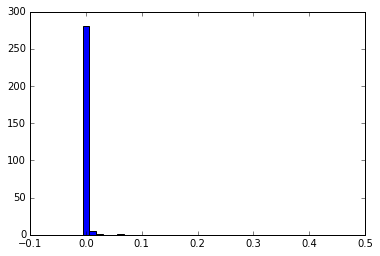

Values[0]:  281.0


In [48]:
# Recall matrix values from brain_id

# setup some arrays to hold data
nans_avg = []
diffs = []
durations = []

# run recall fo network 'samples' number of times
samples = 10
for i in range(samples):
    nans = 0
    diffs_m = []
    
    # for each index in the DEP matrix
    for index in np.ndindex(matrices["zero"].shape):
        
        # for each brain id
        for id_ in brain_id:
            
            # generate data
            data = np.zeros(nodes)-1
            brain_sig = brain_id[id_]
            brain_sig = b_encoder.encode(brain_sig)
            data[-b_encoder.n:] = brain_sig
            
            # set iteration number
            nns[index].setIter(300)
            
            # recall matrix value
            t0 = time.time()
            mem = nns[index].recall(data,(0,m_encoder.n))
            duration = time.time()-t0
            durations.append(duration)
            
            # decode matrix value
            matrix_out = mem[0:m_encoder.nodes]
            
            # calculate error of recalled matrix value
            matrix_decoded = m_encoder.decode_ndarray(matrix_out)
            diff_m = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_][index].reshape(matrix_shape)).flatten())-matrix_decoded
            
            if np.isnan(diff_m):
                nans += 1
            diffs_m.append(diff_m)
    
    nans_avg.append(nans)
    diffs.append(abs(np.array(diffs_m)))
    
# print meta data
print "nans: ", np.max(nans_avg)
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot

# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1
# divide by number of samples to obtain normalized score
values /= samples

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

### Recall matrix from brain id

In [176]:
# setup encoders
m_encoder = scalar_sdr(40,22,-0.25,0.25,(6,12))
b_encoder = scalar_sdr(460,20,0.0,1.0)
# calculate number of nodes
nodes = m_encoder.nodes + b_encoder.n
# initialize hopfield net
hnn = Hopfield_Neural_Network(nodes)

In [177]:
# store data in hnn i.e. brain_id -- matrix[brain_id] pairs
for id_ in brain_id:
    data = np.array([])
    matrix = matrices[id_]
    matrix = m_encoder.encode_ndarray(matrix)
    data = np.append(data,matrix.flatten())

    brain_sig = brain_id[id_]
    brain_sig = b_encoder.encode(brain_sig)
    data = np.append(data,brain_sig)

    hnn.store(data)

mean:  0.0291362847222
max:  0.1875
std:  0.0568160416579
duration:  1.20923197269


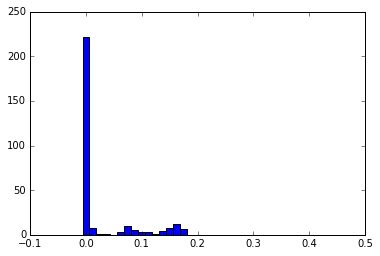

Values[0]:  222.0


In [179]:
durations = []
diffs = []
samples = 10
for i in range(samples):
    for id_ in matrices:
        # setup input with complete brain_id signal
        data = np.zeros(m_encoder.nodes)-1
        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)
        data = np.append(data,brain_sig)
    
        # set number of iterations -- proportional to number of nodes (i.e. 300*72 = 21600)
        hnn.setIter(21600)

        # recall matrix value
        t0 = time.time()
        mem = hnn.recall(data)
        duration = time.time()-t0
        durations.append(duration)

        # decode recalled matrix
        mem_decoded = m_encoder.decode_ndarray(mem[0:m_encoder.nodes])

        # calculate recall error
        matrix_decoded = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_]).flatten())
        diff = mem_decoded-matrix_decoded
        diffs.append(abs(np.array(diff)))

# print meta data
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1
# divide by number of samples to obtain normalized score
values /= samples

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

### Inspecting the Hamming distances of full matrices as memories

In [19]:
def hamming_distance(a,b):
    return len(np.nonzero(a-b)[0])

In [29]:
m_encoder = scalar_sdr(80,22,-0.25,0.25,(6,12))
encoded_matrices = {}
for id_ in brain_id:
    matrix = matrices[id_]
    encoded_matrices[id_] = m_encoder.encode_ndarray(matrix).flatten()

In [30]:
keys = encoded_matrices.keys()
length = len(encoded_matrices[keys[0]])
#print "Length: %i\n" %length
for i in range(len(encoded_matrices)-1):
    for j in range(i+1,len(encoded_matrices)):
        diff = hamming_distance(encoded_matrices[keys[i]],encoded_matrices[keys[j]])
        proportion = float(diff)/length
        print "Ids: %s, %s" %(keys[i],keys[j])
        print "Diff: %i, proportion: %f\n" %(diff,proportion)

Ids: zero, fs
Diff: 2802, proportion: 0.385314

Ids: zero, fb
Diff: 2714, proportion: 0.373212

Ids: zero, sd
Diff: 1894, proportion: 0.260451

Ids: fs, fb
Diff: 1010, proportion: 0.138889

Ids: fs, sd
Diff: 2010, proportion: 0.276403

Ids: fb, sd
Diff: 1980, proportion: 0.272277



In [180]:
# the behaviors are too similar to each other it seems

### Recall matrix from partial matrix for various proportions

Portion - 99.000000
mean:  0.0327690972222
max:  0.3375
std:  0.0670470371519
duration:  0.930240750313


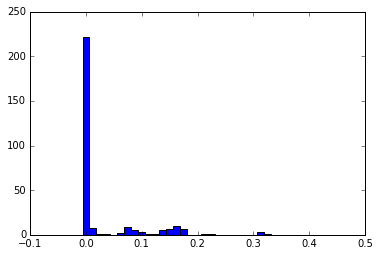

Values[0]:  222.0
Portion - 95.000000
mean:  0.0292100694444
max:  0.1875
std:  0.056817783821
duration:  0.947192847729


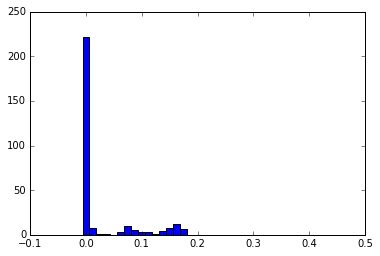

Values[0]:  222.0
Portion - 90.000000
mean:  0.0291232638889
max:  0.1875
std:  0.056967183357
duration:  0.948033332825


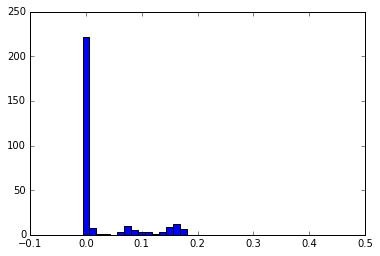

Values[0]:  222.0
Portion - 85.000000
mean:  0.0290798611111
max:  0.1875
std:  0.0569464954534
duration:  0.919963717461


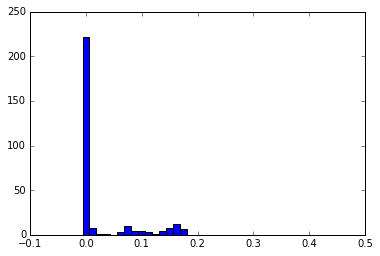

Values[0]:  222.0
Portion - 80.000000
mean:  0.0290364583333
max:  0.1875
std:  0.0567157069412
duration:  0.922077000141


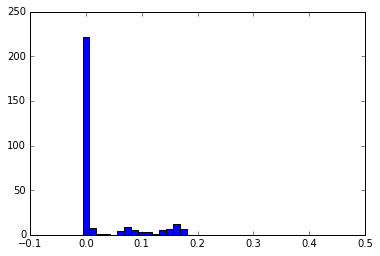

Values[0]:  222.0
Portion - 75.000000
mean:  0.0292534722222
max:  0.1875
std:  0.0568002254656
duration:  1.00283199549


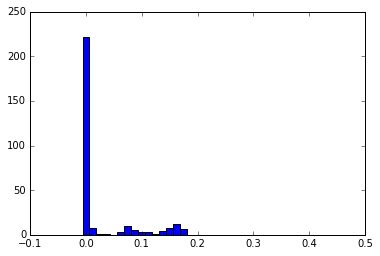

Values[0]:  222.0
Portion - 70.000000
mean:  0.0292534722222
max:  0.1875
std:  0.0568002254656
duration:  0.971389949322


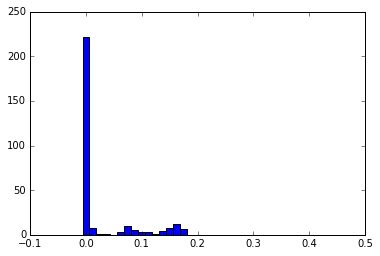

Values[0]:  222.0


In [182]:
m_encoder = scalar_sdr(40,22,-0.25,0.25,(6,12))
nodes = m_encoder.nodes
hnn = Hopfield_Neural_Network(nodes)

for id_ in matrices:
    matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
    hnn.store(matrix)

portions = [99,95,90,85,80,75,70]
for portion in portions:
    diffs = []
    durations = []
    mems = []
    
    print "Portion - %f" %(portion)
    
    for id_ in matrices:
        
        matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
        size = int(float(portion)/float(100)*len(matrix))
        flip_indices = np.random.choice(a=hnn.nodes,size=size,replace=False)
        matrix[flip_indices] = -1

        hnn.setIter(20000)
        t0 = time.time()
        mem = hnn.recall(matrix)
        duration = time.time()-t0
        durations.append(duration)

        mem_decoded = m_encoder.decode_ndarray(mem)
        mems.append(mem_decoded)
        
        matrix_decoded = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_]).flatten())
        diff = mem_decoded-matrix_decoded
        diffs.append(abs(np.array(diff)))

    print "mean: ", np.mean(np.array(diffs).flatten())
    print "max: ", np.max(np.array(diffs).flatten())
    print "std: ", np.std(np.array(diffs).flatten())
    print "duration: ", np.mean(durations)

    categories = []
    max_ = 0.5
    bars = 40
    values = np.zeros(bars)
    for i in range(bars):
        categories.append(i*max_/bars)
    for diff in np.array(diffs).flatten():
        i = int(diff/(max_+0.0000001)*bars)
        values[i] += 1
    plt.figure(1)
    w = categories[1]
    plt.bar(categories, values, w, align='center')
    plt.show()

    print "Values[0]: ", values[0]

In [84]:
#print "pickling experiment data"
#pickle_out = open("experiments_1_2_portion_B300.pickle","wb")
#pickle.dump(experiments, pickle_out)
#pickle_out.close()

### Recall single matrix value from brain_id and single DEP state

In [183]:
m_encoder = scalar_sdr(80,44,-0.25,0.25)
b_encoder = scalar_sdr(46,20,0.0,1.0)
dep_encoder = scalar_sdr(46,20,-0.25,0.25)

In [184]:
nodes =  m_encoder.n + b_encoder.n + dep_encoder.n

In [185]:
nns = {}
for index in np.ndindex(matrices["zero"].shape):
    hnn = Hopfield_Neural_Network(nodes)
    for id_ in brain_id:
        
        matrix = matrices[id_][index]
        matrix = m_encoder.encode(float(matrix))
        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)
        
        for id_dep in matrices:
            data = np.array([])
            data = np.append(data,matrix.flatten())
            data = np.append(data,brain_sig)
            
            dep = matrices[id_dep][index]
            dep = dep_encoder.encode(float(dep))
            data = np.append(data,dep)
            
            hnn.store(data)

    nns[index] = hnn

mean:  0.0293511284722
max:  0.3375
std:  0.0585192417461
duration:  0.00166375161045


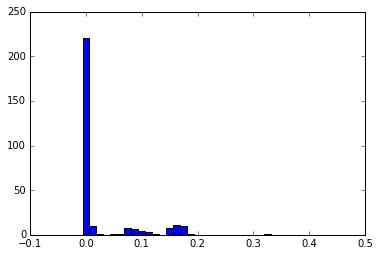

Values[0]:  220.6


In [186]:
diffs = []
durations = []
samples = 10
for i in range(samples):
    for index in np.ndindex(matrices["zero"].shape):
        #print("Index: "+str(index))
        for id_ in brain_id:
            brain_sig = brain_id[id_]
            brain_sig = b_encoder.encode(brain_sig)
            for id_dep in matrices:
                data = np.zeros(m_encoder.n)-1
                data = np.append(data,brain_sig)
                
                dep = matrices[id_dep][index]
                dep = dep_encoder.encode(float(dep))
                data = np.append(data,dep)

                nns[index].setIter(600)
                t0 = time.time()
                mem = nns[index].recall(data,(0,m_encoder.n))
                duration = time.time()-t0
                durations.append(duration)

                matrix_out = mem[0:m_encoder.n]
                matrix_decoded = m_encoder.decode(matrix_out)

                diff = m_encoder.decode(m_encoder.encode(float(matrices[id_][index])))-matrix_decoded
                diffs.append(abs(np.array(diff)))
                  
# print meta data
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1
# divide by number of samplesa and ids to obtain normalized score
values /= samples
values /= len(matrices.keys())

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

#### Recall single matrix value from 2x brain_id

In [23]:
m_encoder = scalar_sdr(80,44,-0.25,0.25)
b_encoder = scalar_sdr(44,20,0.0,1.0)
b_dep_encoder = scalar_sdr(44,20,0.0,1.0)
#pos_encoder = scalar_sdr(44,20,-100000.0,100000.0)
#vel_encoder = scalar_sdr(200,41,-70.0,70.0,(6,))

In [24]:
nodes =  m_encoder.n + b_encoder.n + b_dep_encoder.n

In [25]:
nns = {}
for index in np.ndindex(matrices["zero"].shape):
    hnn = Hopfield_Neural_Network(nodes)
    for id_ in brain_id:
        
        matrix = matrices[id_][index]
        matrix = m_encoder.encode(float(matrix))
        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)
        
        for id_dep in matrices:
            data = np.array([])
            data = np.append(data,matrix.flatten())
            data = np.append(data,brain_sig)
            
            brain_sig1 = brain_id[id_dep]
            brain_sig1 = b_dep_encoder.encode(brain_sig1)
            data = np.append(data,brain_sig1)
            
            hnn.store(data)

    nns[index] = hnn

mean:  0.0299115668403
max:  0.3375
std:  0.0609129751013
duration:  0.00140617763003


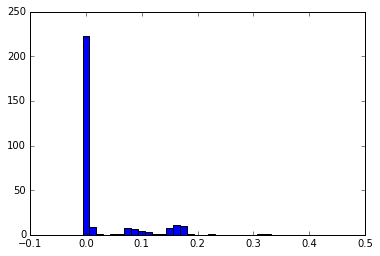

Values[0]:  222.25


In [27]:
diffs = []
durations = []
samples = 10
for i in range(samples):
    for index in np.ndindex(matrices["zero"].shape):
        for id_ in brain_id:
            brain_sig = brain_id[id_]
            brain_sig = b_encoder.encode(brain_sig)
            for id_dep in matrices:
                data = np.zeros(m_encoder.n)-1
                data = np.append(data,brain_sig)
                
                brain_sig1 = brain_id[id_dep]
                brain_sig1 = b_dep_encoder.encode(brain_sig1)
                data = np.append(data,brain_sig1)

                nns[index].setIter(600)
                t0 = time.time()
                mem = nns[index].recall(data,(0,m_encoder.n))
                duration = time.time()-t0
                durations.append(duration)

                matrix_out = mem[0:m_encoder.n]
                matrix_decoded = m_encoder.decode(matrix_out)

                diff = m_encoder.decode(m_encoder.encode(float(matrices[id_][index])))-matrix_decoded
                diffs.append(abs(np.array(diff)))
                
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1
# divide by number of samples and ids to obtain normalized score
values /= samples
values /= len(matrices.keys())

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

# LAM

In [55]:
class LAM:
    def __init__(self,shape,weights=None):
        self.shape = shape
        try:
            if weights == None:
                self.weights = np.zeros(shape)
        except ValueError:
            self.weights = weights
    
    def store(self,input,output):
        dW = np.outer(input,output)
        self.weights += dW
        
    def recall(self,input,threshold=0,print_=False):
        output = input.dot(self.weights)-threshold
        if print_ == True:
            print output
        output[output > 0] = 1
        output[output < 0] = 0
        return output

    def save_weights(self,filename):
        np.save(filename, self.weights)
        
    def load_weights(self,filename):
        weights = np.load(filename)
        if weights.shape == self.shape:
            self.weights = weights
        else:
            raise ValueError("Dimensions of specified weight array does not match network weight dimensions!")

#### Single matrix value from brain_id

In [51]:
matrix_shape = (1,)
m_encoder = scalar_sdr(100,21,-0.25,0.25,matrix_shape,neg=False)
b_encoder = scalar_sdr(100,21,0.0,1.0,neg=False)

In [52]:
nodes = m_encoder.nodes + b_encoder.nodes

In [53]:
nns = {}
for index in np.ndindex(matrices["zero"].shape):
    lma = LAM((b_encoder.n,m_encoder.n))
    for id_ in brain_id:
        matrix = matrices[id_][index]
        matrix = m_encoder.encode(float(matrix)).flatten()

        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)

        lma.store(brain_sig,matrix)

    nns[index] = lma

mean:  0.0
max:  0.0
std:  0.0
duration:  1.78813934326e-05


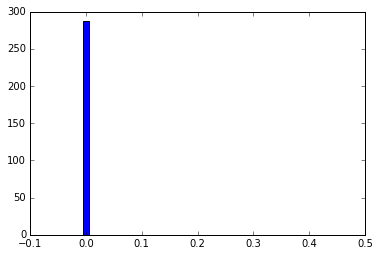

Values[0]:  288.0


In [54]:
diffs = []
durations = []
samples = 10
for i in range(samples):
    for index in np.ndindex(matrices["zero"].shape):
        for id_ in brain_id:
            brain_sig = brain_id[id_]
            brain_sig = b_encoder.encode(brain_sig)

            t0 = time.time()
            mem = nns[index].recall(brain_sig)
            durations = time.time()-t0

            matrix_decoded = m_encoder.decode(mem.reshape(m_encoder.n,1))
            #print matrix_decoded

            diff = m_encoder.decode(m_encoder.encode(float(matrices[id_][index])))-matrix_decoded
            #print m_encoder.decode(m_encoder.encode(float(matrices[id_][index])))
            diffs.append(abs(np.array(diff)))

# print meta data
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1
# divide by number of samples and ids to obtain normalized score
values /= samples

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

#### Full matrix from brain_id

In [65]:
matrix_shape = matrices["zero"].shape
m_encoder = scalar_sdr(100,21,-0.25,0.25,matrix_shape,neg=False)
b_encoder = scalar_sdr(100,21,0.0,1.0,neg=False)

In [66]:
shape = (b_encoder.n,m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape))

In [67]:
lma = LAM(shape)
for id_ in brain_id:
    data = np.array([])
    matrix = matrices[id_]
    matrix = m_encoder.encode_ndarray(matrix)

    data = np.append(data,matrix.flatten())

    brain_sig = brain_id[id_]
    brain_sig = b_encoder.encode(brain_sig)

    data = np.append(data,brain_sig)

    lma.store(brain_sig,matrix)

In [69]:
pickle_out = open("lam.pickle","wb")
pickle.dump(lma, pickle_out)
pickle_out.close()

mean:  0.0
max:  0.0
std:  0.0
duration:  0.0021653175354


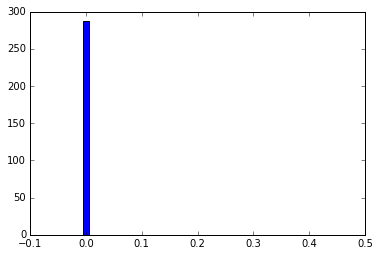

Values[0]:  288.0


In [68]:
diffs = []
durations = []
for i in range(1):
    for id_ in brain_id:
        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)

        t0 = time.time()
        mem = lma.recall(np.array(brain_sig))
        duration = time.time()-t0
        durations.append(duration)

        matrix_decoded = m_encoder.decode_ndarray(np.array(mem).reshape((reduce(lambda x, y: x*y, m_encoder.ndarray_shape)*m_encoder.n,)))
        diff = m_encoder.decode_ndarray(np.array(m_encoder.encode_ndarray(matrices[id_])).reshape((reduce(lambda x, y: x*y, m_encoder.ndarray_shape)*m_encoder.n,)))-matrix_decoded
        diffs.append(diff)

# print meta data
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

### Full matrix from brain id, brain id, position and velocity

In [40]:
import matplotlib.pyplot as plt

In [41]:
matrix_shape = matrices["zero"].shape
matrix_encoder = scalar_sdr(80,44,-0.25,0.25,matrix_shape,neg=False)
brain_encoder = scalar_sdr(1000,210,0.0,1.0,neg=False)
state_encoder = scalar_sdr(40,22,-0.25,0.25,matrix_shape,neg=False)
#pos_encoder = scalar_sdr(1000,21,-100000.0,100000.0,shape=pos["zero"].shape,neg=False)
#vel_encoder = scalar_sdr(1000,21,-70.0,70.0,shape=vel["zero"].shape,neg=False)

In [42]:
#shape = (brain_encoder.n*2+pos_encoder.n*reduce(lambda x, y: x*y, pos_encoder.ndarray_shape)+vel_encoder.n*reduce(lambda x, y: x*y, vel_encoder.ndarray_shape),matrix_encoder.n*reduce(lambda x, y: x*y, matrix_encoder.ndarray_shape))
shape = (brain_encoder.n+state_encoder.n*reduce(lambda x, y: x*y, state_encoder.ndarray_shape), matrix_encoder.n*reduce(lambda x, y: x*y, matrix_encoder.ndarray_shape))

In [43]:
lam = LAM(shape)

In [44]:
for id_ in brain_id:
    input_ = np.array([])
    
    state_id = state_encoder.encode_ndarray(matrices["zero"]) # Note: this is not changed since it is sensory
    input_ = np.append(input_,state_id.flatten())
    
    #motor_pos = pos_encoder.encode_ndarray(pos["zero"])
    #input_ = np.append(input_,motor_pos.flatten())
    
    #motor_vel = vel_encoder.encode_ndarray(vel["zero"])
    #input_ = np.append(input_,motor_vel.flatten())
    
    brain_sig = brain_encoder.encode(brain_id[id_])
    input_ = np.append(input_,brain_sig.flatten())

    output = matrix_encoder.encode_ndarray(matrices[id_])
    
    lam.store(input_,output)

mean:  0.0609592013889
max:  0.2625
std:  0.108928588325
duration:  0.000935316085815


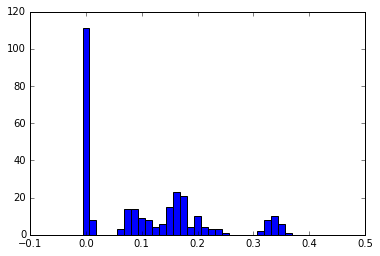

Values[0]:  111.0


In [45]:
diffs = []

for id_ in brain_id:
    input_ = np.array([])
    
    #state_id = state_encoder.encode(brain_id["zero"])
    state_id = state_encoder.encode_ndarray(matrices["zero"])
    input_ = np.append(input_,state_id.flatten())
    
    #motor_pos = pos_encoder.encode_ndarray(pos["zero"])
    #input_ = np.append(input_,motor_pos.flatten())
    
    #motor_vel = vel_encoder.encode_ndarray(vel["zero"])
    #input_ = np.append(input_,motor_vel.flatten())
    
    brain_sig = brain_encoder.encode(brain_id[id_])
    input_ = np.append(input_,brain_sig.flatten())
    
    mem = lam.recall(input_)
    
    matrix_decoded = matrix_encoder.decode_ndarray(np.array(mem).reshape((reduce(lambda x, y: x*y, matrix_encoder.ndarray_shape)*matrix_encoder.n,)))
    
    diff = matrix_encoder.decode_ndarray(np.array(matrix_encoder.encode_ndarray(matrices[id_])).reshape((reduce(lambda x, y: x*y, matrix_encoder.ndarray_shape)*matrix_encoder.n,)))-matrix_decoded

    diffs.append(diff)

# print meta data
print "mean: ", np.mean(np.array(diffs).flatten())
print "max: ", np.max(np.array(diffs).flatten())
print "std: ", np.std(np.array(diffs).flatten())
print "duration: ", np.mean(durations)

# Bar graph plot
# plotting constants 
max_ = 0.5
bars = 40

# calculate category indices
categories = []
for i in range(bars):
    categories.append(i*max_/bars)
width = categories[1]

# tally number of instances for each category
values = np.zeros(bars)
for diff in np.array(diffs).flatten():
    i = int(diff/(max_+0.0000001)*bars)
    values[i] += 1

# plot bar graph
plt.figure(1)
plt.bar(categories, values, width, align='center')
plt.show()

# print number of values that fall into first category (good approximation of how well the memory does)
print "Values[0]: ", values[0]

### Trigger signal from motor status

In [65]:
class category_sdr:
    def __init__(self,categories,width=20):
        self.letters = len(categories[0])
        if len(np.nonzero(np.array([len(i) for i in categories])-len(categories[0]))[0]) != 0:
            raise ValueError("Categories must have equal lengths!")
        self.categories = categories
        self.encoder = scalar_sdr(128,width,0.0,128.0,(self.letters,1),neg=False)
        self.nodes = self.letters*self.encoder.n
        
    def encode(self,input_):
        if input_ not in self.categories:
            raise ValueError("Not valid category")
        output = self.encoder.encode_ndarray(np.array([ord(i) for i in input_]).reshape(self.encoder.ndarray_shape)).flatten()
        return output
    
    def decode(self,input_):
        max_ = 0
        cat = ''
        for category in self.categories:
            cat_enc = self.encode(category)
            score = len(np.nonzero(cat_enc*input_)[0])
            if score > max_:
                max_ = score
                cat = category
        return cat

#### Hopfield

#### Category from single sensor channel

In [ ]:
pos_encoder = scalar_sdr(40,22,-100000.0,100000.0)
categories = ['ZEROzero','11oneONE']
output_encoder = category_sdr(categories,width=45)

#### Category from sensor array

In [ ]:
# initialize encoders
pos_encoder = scalar_sdr(40,22,-100000.0,100000.0,shape=pos["zero"].shape)
vel_encoder = scalar_sdr(40,22,-70.0,70.0,shape=vel["zero"].shape)
categories = ['ZEROzero','11oneONE']
output_encoder = category_sdr(categories,width=45)

pos_nodes = pos_encoder.nodes
vel_nodes = vel_encoder.nodes
output_nodes = output_encoder.nodes
nodes = int(pos_nodes+vel_nodes+output_nodes)

# initialize hnn
hnn = Hopfield_Neural_Network(nodes)

In [60]:
#diff = hamming_distance(output_encoder.encode(categories[0]),output_encoder.encode(categories[1]))
#length = len(output_encoder.encode(categories[0]))
#proportion = float(diff)/length
#print "Diff: %i, length: %i, proportion: %f\n" %(diff,length,proportion)

In [62]:
# store memories of transition points with position, velocity and output
ts = {'fb': 124, 'fs': 126, 'sd': 117}
for base in bases:
    for i in range(bases[base][0].shape[0]):
        
        input_ = np.array([])

        motor_pos = pos_encoder.encode_ndarray(bases[base][0][i][active_motors])
        input_ = np.append(input_,motor_pos.flatten())

        motor_vel = vel_encoder.encode_ndarray(bases[base][1][i][active_motors])
        input_ = np.append(input_,motor_vel.flatten())

        if i == ts[base]:
            output = output_encoder.encode(categories[1])
        else:
            output = output_encoder.encode(categories[0])
            
        input_ = np.append(input_,output.flatten())
        hnn.store(input_)

In [63]:
# attempt recall on all possibilities in position data
ones = 0
zeros = 0
for base in bases:
    for i in range(bases[base][0].shape[0]):
        input_ = np.array([])
        
        motor_pos = pos_encoder.encode_ndarray(bases[base][0][i][active_motors])
        input_ = np.append(input_,motor_pos.flatten())

        motor_vel = vel_encoder.encode_ndarray(bases[base][1][i][active_motors])
        input_ = np.append(input_,motor_vel.flatten())

        out = np.zeros(output_nodes)-1
        input_ = np.append(input_,out)
        
        hnn.setIter(10)
        output = hnn.recall(np.array(input_),(output_nodes,nodes))
        if output_encoder.decode(output[-output_nodes:].transpose()) == '11oneONE':
            ones += 1
        else:
            zeros += 1
print ones,zeros

0 380


In [64]:
# Well the zeros overpower, argh

#### LAM

In [111]:
pos_encoder = scalar_sdr(80,44,-100000.0,100000.0,shape=pos["zero"].shape,neg=False)
vel_encoder = scalar_sdr(80,44,-70.0,70.0,shape=vel["zero"].shape,neg=False)
#output_encoder = category_sdr(categories,width=20)
output_encoder = scalar_sdr(200,100,0.,400.,neg=False)

In [112]:
pos_nodes = pos_encoder.n*reduce(lambda x, y: x*y, pos_encoder.ndarray_shape)
vel_nodes = vel_encoder.n*reduce(lambda x, y: x*y, vel_encoder.ndarray_shape)
output_nodes = output_encoder.n
shape = (pos_nodes+vel_nodes, output_nodes)

In [113]:
lam = LAM(shape)

In [114]:
ts = {'fb': 124, 'fs': 126, 'sd': 117}
map_ = {'fb': 0., 'fs': 1., 'sd': 2.}
for base in bases:
    for i in range(bases[base][0].shape[0]):
        input_ = np.array([])
        
        motor_pos = pos_encoder.encode_ndarray(bases[base][0][i][active_motors])
        input_ = np.append(input_,motor_pos.flatten())

        motor_vel = vel_encoder.encode_ndarray(bases[base][1][i][active_motors])
        input_ = np.append(input_,motor_vel.flatten())

        #output = output_encoder.encode(categories[1])
        output = output_encoder.encode(i+130*map_[base])
        lam.store(input_,output)

In [131]:
for id_ in bases:
    print id_
    input_ = np.array([])
    
    motor_pos = pos_encoder.encode_ndarray(pos[id_])
    input_ = np.append(input_,motor_pos.flatten())
    
    motor_vel = vel_encoder.encode_ndarray(vel[id_])
    input_ = np.append(input_,motor_vel.flatten())

    output = lam.recall(np.array(input_),threshold=58000).flatten()
    #print output
    print output_encoder.decode(output)

fb
182.0
fs
184.0
sd
196.0


#### Hard coded neurons

In [18]:
active_motors = [1,3,4,5,10,12]
ts = {'fb': 124, 'fs': 126, 'sd': 117}

In [19]:
# output is taken dependent upon position; position node firing is inhibited by incorrect velocities

In [20]:
pos_encoder = scalar_sdr(30,1,-100000.0,100000.0,neg=False)
vel_encoder = scalar_sdr(10,1,-70.0,70.0,neg=False)
weights = []
weights_vel = []
for i in active_motors:
    w = np.zeros(pos_encoder.nodes)
    w_vel = np.array([np.zeros(vel_encoder.nodes) for j in range(pos_encoder.nodes)])
    for id_ in bases:
        val = bases[id_][0][ts[id_]][i]
        index_pos = int((val-pos_encoder.min)/(pos_encoder.max-pos_encoder.min)*pos_encoder.b)
        w[index_pos] = 1

        w_vel[index_pos] = vel_encoder.encode(float(bases[id_][1][ts[id_]][i]))-1
    weights.append(w)
    weights_vel.append(w_vel)
weights = np.array(weights)
weights_vel = np.array(weights_vel)

In [21]:
#id_ = 'sd'
#trigger = weights[0]*pos_encoder.encode(float(bases[id_][0][ts[id_]][1]))+np.sum(weights_vel[0]*vel_encoder.encode(float(bases[id_][1][ts[id_]][1])),axis=1)
#trigger[trigger < 0] = 0 

In [22]:
pos_encoder = scalar_sdr(30,1,-100000.0,100000.0,shape=(len(active_motors),1),neg=False)
vel_encoder = scalar_sdr(10,1,-70.0,70.0,shape=(len(active_motors),1),neg=False)

pos_ = pos_encoder.encode_ndarray(bases[id_][0][ts[id_]][active_motors].reshape(6,1)).reshape(6,30,1)
vel_ = vel_encoder.encode_ndarray(bases[id_][1][ts[id_]][active_motors].reshape(6,1)).reshape(6,10,1)

weights = weights.reshape(6,30,1)
weights_vel = weights_vel.reshape(6,30,10)

In [24]:
import tensorflow as tf
import numpy as np

with tf.name_scope("input"):
    pos_nodes = tf.placeholder(tf.float32, [6,30,1], name="encoded_motor_positions")
    vel_nodes = tf.placeholder(tf.float32, [6,10,1], name="encoded_motor_velocities")

with tf.name_scope("weights")
    w_pos = tf.Variable(np.zeros((6,30,1)), name="position_weights", dtype=tf.float32)
    w_vel = tf.Variable(np.zeros((6,30,10)), name="velocity_weights", dtype=tf.float32)

with tf.name_scope("trigger"):
    a = tf.multiply(pos_nodes,w_pos)
    b = tf.matmul(w_vel,vel_nodes)
    c = a + b
    trigger = tf.nn.relu(tf.sign(c))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
sess.run(d,{pos_nodes: pos_, w_pos: weights, vel_nodes: vel_, w_vel: weights_vel})

# Create a summary writer, add the 'graph' to the event file.
writer = tf.summary.FileWriter("tf_logs", sess.graph)
